In [22]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import acquire

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# get dataframe from acquire module
df = acquire.get_df()

In [3]:
df.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1648094400000,2022-03-24 04:00:00,BTCUSD,42754.74,42811.28,42754.74,42801.43,0.733911
1,1648008000000,2022-03-23 04:00:00,BTCUSD,42101.27,43295.15,41777.00,42754.74,1087.202534
2,1647921600000,2022-03-22 04:00:00,BTCUSD,42240.26,43359.99,41929.87,42101.27,1406.953520
3,1647835200000,2022-03-21 04:00:00,BTCUSD,40861.30,42500.00,40758.16,42240.26,879.141935
4,1647748800000,2022-03-20 04:00:00,BTCUSD,41969.76,42019.07,40529.07,40861.30,436.605166


In [4]:
# rename columns for ease of use
df.rename(columns= {'Unix Timestamp':'unix','Date':'date','Symbol':'symbol','Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'}, inplace = True)

In [5]:
# change date column to datetime
df.date = pd.to_datetime(df.date)

# set the index to the date
df = df.set_index('date').sort_index()

# create day of week column for exploration use
df['day_of_week'] = df.index.day_name()

In [48]:
categorical_columns = ['symbol','day_of_week']
categories = [[df.symbol.value_counts().index.to_list()]]

In [47]:
# how many days of each crypto are in the dataframe
df.symbol.value_counts()

BTCUSD    2360
ETHUSD    2146
LTCUSD    1256
Name: symbol, dtype: int64

<AxesSubplot:xlabel='date'>

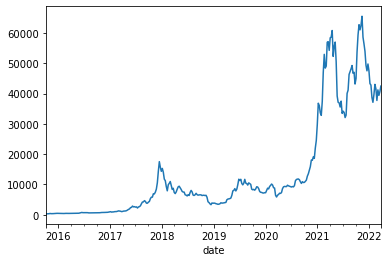

In [7]:
# check the daily mean of closing price for bitcoin
df[df.symbol == 'BTCUSD'].resample('W').close.mean().plot()

<AxesSubplot:xlabel='date'>

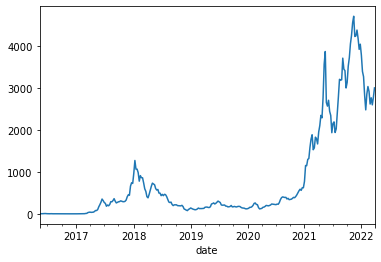

In [8]:
# repeat for etherium
df[df.symbol == 'ETHUSD'].resample('W').close.mean().plot()

<AxesSubplot:xlabel='date'>

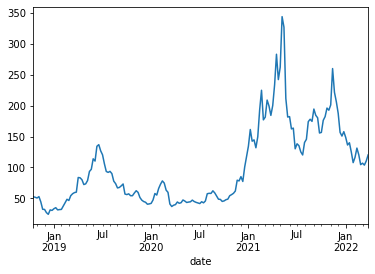

In [9]:
# repeat for lightcoin
df[df.symbol == 'LTCUSD'].resample('W').close.mean().plot()

With the massive hike in crypto in 2021, cutting out earlier dates may improve modeling

In [10]:
# create second dataframe of dates >= 2021
df2 = df[df.index >= "2021"]

In [11]:
# we should have the same amount of obserations for each cryptocurrency now
df2.symbol.value_counts()

BTCUSD    448
ETHUSD    448
LTCUSD    448
Name: symbol, dtype: int64

<AxesSubplot:xlabel='date'>

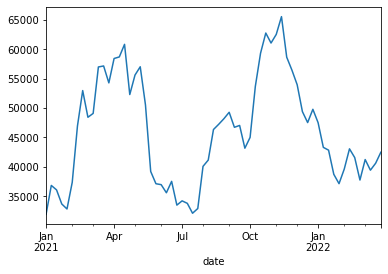

In [12]:
# double check plot 
df2[df2.symbol == 'BTCUSD'].resample('W').close.mean().plot()

It does not look like there is a seasonality and with the volatility of crypto, Cross Validation might be the best approach to splitting the data.

In [14]:
# define X and y for splitting
X = df.drop(columns = 'close')
y = df.close

In [15]:
# create the splitter
# test_size set to 60 to cover two months of data
# gap of 1 day between train/test
tscv = TimeSeriesSplit(n_splits = 5, test_size = 60, gap = 1)

In [16]:
# use the splitter
all_splits = list(tscv.split(X, y))

In [17]:
# check first split
train_0, test_0 = all_splits[0]

In [18]:
# double check split shapes
print(X.iloc[train_0].shape)
print(X.iloc[test_0].shape)

(5461, 7)
(60, 7)


In [36]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )
    return rmse.mean()

In [52]:
# ordinal_encoder = OrdinalEncoder(categories=categories)


# gbrt_pipeline = make_pipeline(
#     ColumnTransformer(
#         transformers=[
#             ("categorical", ordinal_encoder, categorical_columns),
#         ],
#         remainder="passthrough",
#     ),
#     HistGradientBoostingRegressor(
#         categorical_features=range(3),
#     ),
# )

# evaluate(gbrt_pipeline, X, y, cv=tscv)


In [37]:
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
alphas = np.logspace(-6, 6, 25)
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, ['symbol','day_of_week']),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)


lm_rmse = evaluate(naive_linear_pipeline, X, y, cv=tscv)

Mean Absolute Error:     180.932 +/- 30.559
Root Mean Squared Error: 381.673 +/- 79.132


In [39]:
df.close.mean()

5845.860057271779